In [1]:
from strategy.competition import Competition
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
import numpy as np
import matplotlib.pyplot as plt

In [2]:
start_date = datetime(2016,1,1)
end_date = datetime(2021,1,1)
comp = Competition(start_date,end_date)

In [3]:
comp.subscribe()
initial_data = comp.initial_transform()
# sim = comp.create_sim()

In [ ]:
start_year = comp.start_date.year
end_year = comp.end_date.year
categories_nums = comp.modeling_params["categories"]
model_training_year = comp.modeling_params["model_training_year"]
sims = []
market = comp.subscriptions["market"]["db"]
market.connect()
sp5 = market.retrieve("sp500")
comp.db.connect()
for year in tqdm(range(2017,2018),desc="competition_sim_year"):
    for quarter in tqdm(range(4,5),desc="competition_sim_quarter"):
        for ticker in tqdm(list(sp5["Symbol"].unique()),desc="competition_sim_ticker"):
            try:
                model_data = comp.db.retrieve_transformed(ticker)
                model_data.sort_values("date",ascending=True,inplace=True)
                model_data.reset_index(inplace=True,drop=True)
                first_index = model_data[(model_data["year"] == (year - model_training_year - 1)) & (model_data["quarter"]==quarter)].index.values.tolist()[0]
                last_index = model_data[(model_data["year"] == year) & (model_data["quarter"]==quarter)].index.values.tolist()[0]
                training_data = model_data.iloc[first_index:last_index].reset_index(drop=True)
                prediction_data = model_data[(model_data["year"] == year) & (model_data["quarter"]==quarter)].reset_index()
                factor_cols = [x for x in training_data.columns if x not in ["year","quarter","week","y","ticker","date"]]
                X = training_data[factor_cols]
                y = training_data["y"]
                models = m.regression({"X":X,"y":y})
                models["year"] = year
                models["quarter"] = quarter
                sim = prediction_data
                for i in range(models.index.size):
                    model = models.iloc[i]
                    api = model["api"]
                    score = model["score"]
                    if score >= comp.modeling_params["score_requirement"]/100:
                        sim[f"{api}_prediction"] = model["model"].predict(sim[factor_cols])
                        sim[f"{api}_score"] = model["score"].item()
                ticker_data = market.retrieve_ticker_prices("prices",ticker)
                prices = p.column_date_processing(ticker_data)
                prices["year"] = [x.year for x in prices["date"]]
                prices["week"] = [x.week for x in prices["date"]]
                sim = p.column_date_processing(sim)
                sim["year"] = [x.year for x in sim["date"]]
                sim["week"] = [x.week for x in sim["date"]]
                sim = prices[["date","year","week","ticker","adjclose"]].merge(sim.drop("date",axis=1),on=["year","week","ticker"],how="right").dropna()
                sim["categories"] = categories_nums
                final_cols = ["date","ticker","adjclose","categories"]
                final_cols.extend([x for x in list(sim.columns) if "prediction" in x or "score" in x])
                sim = sim[final_cols]
                sim.fillna(0,inplace=True)
                sim["prediction"] = [np.nanmean([row[1][x] for x in sim.columns if "prediction" in x and row[1][x] != 0]) for row in sim.iterrows()]
                sim["score"] = [np.nanmean([row[1][x] for x in sim.columns if "score" in x and row[1][x] != 0]) for row in sim.iterrows()]
                sim["delta"] = (sim["prediction"] - sim["adjclose"]) / sim["adjclose"]
                for param in comp.modeling_params:
                    sim[param]=comp.modeling_params[param]
                if sim.index.size > 1:
                    comp.db.store("sim",sim)
                    sims.append(sim)
            except Exception as e:
                print(ticker,str(e))
comp.db.disconnect()
market.disconnect()

competition_sim_quarter:   0%|                                                                                                        | 0/1 [00:00<?, ?it/s]

competition_sim_ticker:   0%|                                                                                                       | 0/505 [00:00<?, ?it/s]Custom logger is already specified. Specify more than one logger at same time is not thread safe.

competition_sim_ticker:   0%|▏                                                                                            | 1/505 [00:50<7:07:00, 50.83s/it]

competition_sim_ticker:   0%|▎                                                                                            | 2/505 [01:42<7:10:40, 51.37s/it]

competition_sim_ticker:   1%|▌                                                                                            | 3/505 [02:30<6:57:39, 49.92s/it]

competition_sim_ticker:   1%|▋                                                                                   

Input contains NaN, infinity or a value too large for dtype('float64').
[09:42:32] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/data/data.cc:367: Check failed: valid: Label contains NaN, infinity or a value too large.
For early stopping, at least one dataset and eval metric is required for evaluation


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

competition_sim_ticker:   5%

C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/metrics/metric.cpp:6426: metric/loss-function RMSE do not allows nan value on target


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

competition_sim_ticker:   5%|████▉                                                                                       | 27/505 [18:12<3:41:02, 27.75s/it]

competition_sim_ticker:   6%|█████                                                                                       | 28/505 [19:08<4:49:38, 36.43s/it]

competition_sim_ticker:   6%|█████▎                                                                                      | 29/505 [19:37<4:30:43, 34.12s/it]

In [35]:
sim.head(2)

,date,ticker,adjclose,categories,skl_prediction,skl_score,xgb_prediction,xgb_score,cat_prediction,cat_score,prediction,score,delta,model_training_year,score_requirement
0,2017-10-02,MO,48.095504,2,49.516927,0.976333,48.02523,0.950882,48.381998,0.959842,48.641385,0.962352,0.011350,1,70
1,2017-10-03,MO,48.454882,2,49.516927,0.976333,48.02523,0.950882,48.381998,0.959842,48.641385,0.962352,0.003849,1,70


In [36]:
models

,api,model,score,model_type,year,quarter
0,skl,LinearRegression(),0.976333,regression,2017,4
1,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.950882,regression,2017,4
2,light,"LGBMRegressor(boosting_type='dart', early_stop...",-0.468264,regression,2017,4
3,cat,<catboost.core.CatBoostRegressor object at 0x0...,0.959842,regression,2017,4


In [37]:
analysis = pd.concat(sims)

In [38]:
analysis.head(2)

,date,ticker,adjclose,categories,skl_prediction,skl_score,xgb_prediction,xgb_score,cat_prediction,cat_score,prediction,score,delta,model_training_year,score_requirement
0,2017-01-03,MO,50.350861,2,51.680494,0.988843,50.601513,0.980703,50.232957,0.978591,50.838321,0.982712,0.009681,1,70
1,2017-01-04,MO,50.514652,2,51.680494,0.988843,50.601513,0.980703,50.232957,0.978591,50.838321,0.982712,0.006407,1,70


In [39]:
analysis["year"] = [x.year for x in analysis["date"]]
analysis["week"] = [x.quarter for x in analysis["date"]]
# analysis["date"] = [datetime.strptime(f'{row[1]["year"]} {row[1]["week"]} 0', "%Y %W %w") for row in analysis.iterrows()]

In [40]:
analysis

,date,ticker,adjclose,categories,skl_prediction,skl_score,xgb_prediction,xgb_score,cat_prediction,cat_score,prediction,score,delta,model_training_year,score_requirement,year,week
0,2017-01-03,MO,50.350861,2,51.680494,0.988843,50.601513,0.980703,50.232957,0.978591,50.838321,0.982712,0.009681,1,70,2017,1
1,2017-01-04,MO,50.514652,2,51.680494,0.988843,50.601513,0.980703,50.232957,0.978591,50.838321,0.982712,0.006407,1,70,2017,1
2,2017-01-05,MO,50.574213,2,51.680494,0.988843,50.601513,0.980703,50.232957,0.978591,50.838321,0.982712,0.005222,1,70,2017,1
3,2017-01-06,MO,50.797564,2,51.680494,0.988843,50.601513,0.980703,50.232957,0.978591,50.838321,0.982712,0.000802,1,70,2017,1
4,2017-01-09,MO,50.589103,2,52.579889,0.988843,50.110916,0.980703,49.444346,0.978591,50.711717,0.982712,0.002424,1,70,2017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2017-12-22,MO,55.662186,2,54.766708,0.976333,55.135834,0.950882,50.632520,0.959842,53.511688,0.962352,-0.038635,1,70,2017,4
59,2017-12-26,MO,55.615891,2,54.260909,0.976333,55.138710,0.950882,50.922199,0.959842,53.440606,0.962352,-0.039113,1,70,2017,4
60,2017-12-27,MO,55.885946,2,54.260909,0.976333,55.138710,0.950882,50.922199,0.959842,53.440606,0.962352,-0.043756,1,70,2017,4
61,2017-12-28,MO,54.990907,2,54.260909,0.976333,55.138710,0.950882,50.922199,0.959842,53.440606,0.962352,-0.028192,1,70,2017,4


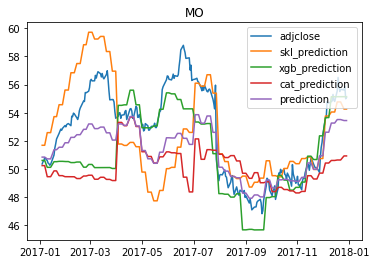

In [41]:
ticker_example = analysis[analysis["ticker"]==ticker].sort_values("date")
plt.plot(ticker_example["date"],ticker_example["adjclose"])
for col in [x for x in analysis.columns if "prediction" in x]:
    plt.plot(ticker_example["date"],ticker_example[col])
legend = ["adjclose"]
legend.extend([x for x in analysis.columns if "prediction" in x])
plt.legend(legend)
plt.title(ticker)
plt.show()